# Load a pretrained model
## Classifier: ResNext101
- We need to download a pretrained model
- The name of the .pth file informs on the dataset that was used in the pretraining, the model architecture, and parameters (like cardinality)
- We need to create an instance of the same model (without training), then load the state dict (which contains the values of the parameters for every layer 

In [9]:
import torch
from demo.models.resnext import resnext101
from collections import OrderedDict

In [10]:
# path to the downloaded pretrained model
# in this case, it is a ResNext 101 layers trained on the Jester dataset
pretrained_model = "C:/Users/souhe/Documents/repositories/Real-time-GesRec/pretrained/jester_resnext_101_RGB_32.pth"

In [11]:
def get_state_dict(path_to_model: str):
    """Return the state dict by loading a .pth pretrained model."""
    state_dict = torch.load(path_to_model, map_location="cpu")["state_dict"]
    # replace "module.layer.weight" by "layer.weight" and so on for biases too
    new_state = OrderedDict([(key.replace("module.", ""), value) for key, value in state_dict.items()])
    return new_state

In [13]:
# model parameters 
# sample size = 112 (size of the image: 112 * 112)
# sample_duration = 16 (16 frames for the 3D convolution)
# shortcut_type = "B" (default value)
# cardinality =32 (as in the model name)
# num_classes = 27 (Jester dataset targets)
model = resnext101(sample_size=112, sample_duration=16, shortcut_type="B", cardinality=32, num_classes=27)

# load the state dict 
model.load_state_dict(get_state_dict(pretrained_model))

..\demo\models\resnext.py:129: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


<All keys matched successfully>

### Model's architecture

In [17]:
print(model)

ResNeXt(
  (conv1): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNeXtBottleneck(
      (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=32, bias=False)
      (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv3d(128, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequentia

### Test input

In [18]:
print(model.conv1)

Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)


- The first layer of the CNN is a Conv3D layer with the following parameters:
- in_channels = 3
- out_channels = 64
- kernel_size = 7
- stride = (1, 2, 2)
- padding = 3
- bias = False (no learnable bias parameter)

We need then to feed this layer an input of shape [batch_size, channels_in, dimension_in, height, width] with:
- channels_in = 3
- dimension_in = 16
- height = width = 112

Test with synthetic data

In [21]:
from torch import nn
import torch.nn.functional as F


m = nn.Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
# input: batch_size, channels_in, dimension_in, height, width
input_images = torch.randn(1, 3, 16, 112, 112)
output = m(input_images)
print("First layer: Conv3d")
print(f"Input of size: {input_images.shape}")
print(f"Output of size: {output.shape}")

First layer: Conv3d
Input of size: torch.Size([1, 3, 16, 112, 112])
Output of size: torch.Size([1, 64, 16, 56, 56])


In [23]:
# evaluation mode
model.eval()

# output of the model
output = model(input_images)
# give probabilities
print(F.softmax(output, dim=1))

tensor([[0.1395, 0.0377, 0.0899, 0.0383, 0.0591, 0.0199, 0.0400, 0.0237, 0.0205,
         0.0310, 0.0361, 0.0117, 0.0114, 0.0317, 0.0384, 0.0350, 0.0076, 0.0098,
         0.0323, 0.0167, 0.0570, 0.0373, 0.0332, 0.0364, 0.0352, 0.0354, 0.0352]],
       grad_fn=<SoftmaxBackward>)


### Test with images from the dataset
- We need to read the images, then (at least) rescale them at 112 * 112, then feed them to the model in a tensor of the correct size (16 frames)

In [29]:
# import some real images
import glob
from PIL import Image
import os
from demo.spatial_transforms import Compose, Scale, CenterCrop, ToTensor, Normalize
from demo.temporal_transforms import TemporalCenterCrop


test_dir = "../test_samples/82"
filenames = glob.glob(os.path.join(test_dir, "*.jpg"))

im = Image.open(filenames[0])

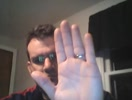

In [33]:
im

In [35]:
print(f"Image size: {im.size}")

Image size: (132, 100)


In [ ]:
spatial_transform = Compose([
    Scale(112),
    CenterCrop(112),
    ToTensor(255), Normalize([0, 0, 0], [1, 1, 1])
])

- we need to rescale a list of 16 images into 112 * 112

In [44]:
x = []
for filename in filenames[:16]:
    img = Image.open(filename)
    img = spatial_transform(img)
    x.append(img)
x = torch.stack(x).reshape(1, 3, 16, 112, 112)
print(x.shape)

torch.Size([1, 3, 16, 112, 112])


In [45]:
model.eval()

# output of the model
output = model(x)
# give probabilities
print(F.softmax(output, dim=1))

tensor([[0.1388, 0.0368, 0.0882, 0.0391, 0.0584, 0.0214, 0.0404, 0.0253, 0.0224,
         0.0314, 0.0359, 0.0116, 0.0114, 0.0321, 0.0386, 0.0360, 0.0079, 0.0105,
         0.0329, 0.0173, 0.0541, 0.0371, 0.0330, 0.0365, 0.0338, 0.0354, 0.0339]],
       grad_fn=<SoftmaxBackward>)


In [51]:
torch.argmax(F.softmax(output, dim=1))

tensor(0)

wrong output! it should be stop sign!

In [53]:
test_dir = "../test_samples/300"
filenames = glob.glob(os.path.join(test_dir, "*.jpg"))

im = Image.open(filenames[-1])

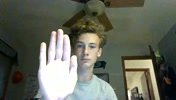

In [54]:
im

In [55]:
print(f"Image size: {im.size}")

Image size: (176, 100)


In [57]:
x = []
for filename in filenames[-16:]:
    img = Image.open(filename)
    img = spatial_transform(img)
    x.append(img)
x = torch.stack(x).reshape(1, 3, 16, 112, 112)
print(x.shape)

torch.Size([1, 3, 16, 112, 112])


In [58]:
model.eval()

# output of the model
output = model(x)
# give probabilities
print(F.softmax(output, dim=1))

tensor([[0.1404, 0.0369, 0.0878, 0.0393, 0.0585, 0.0215, 0.0401, 0.0253, 0.0224,
         0.0313, 0.0357, 0.0114, 0.0113, 0.0318, 0.0389, 0.0360, 0.0079, 0.0105,
         0.0327, 0.0172, 0.0540, 0.0372, 0.0329, 0.0365, 0.0335, 0.0353, 0.0336]],
       grad_fn=<SoftmaxBackward>)


### NOT WORKING
the model give almost the same probabilities